
# Data Reading Prepration

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import glob
from dateutil.parser import parse
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#id
%cd gdrive/MyDrive/Sajjad_cloned_ready
!unzip 'Sajjad cloned_id.zip'

/content/gdrive/MyDrive/Sajjad_cloned_ready
Archive:  Sajjad cloned_id.zip
replace 1 (12)/296707.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# #2_channels
# %cd gdrive/MyDrive/Sajjad_cloned_ready
# !unzip 2_Channels.zip
# %cd Données-Copie-Sept 2020_2_channel

In [5]:
%cd
%cd /content/gdrive/MyDrive/
!git clone https://github.com/cyrus1123/trans-2022-17.git
%cd trans-2022-17
!unzip transformers-main.zip
%cd transformers-main
!pip install /content/gdrive/MyDrive/trans-2022-17/transformers-main

/root
/content/gdrive/MyDrive
fatal: destination path 'trans-2022-17' already exists and is not an empty directory.
/content/gdrive/MyDrive/trans-2022-17
Archive:  transformers-main.zip
replace transformers-main/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: transformers-main/.circleci/config.yml  
  inflating: transformers-main/.circleci/create_circleci_config.py  
  inflating: transformers-main/.circleci/TROUBLESHOOT.md  
  inflating: transformers-main/.coveragerc  
  inflating: transformers-main/.gitattributes  
  inflating: transformers-main/.github/conda/build.sh  
  inflating: transformers-main/.github/conda/meta.yaml  
  inflating: transformers-main/.github/ISSUE_TEMPLATE/bug-report.yml  
  inflating: transformers-main/.github/ISSUE_TEMPLATE/config.yml  
  inflating: transformers-main/.github/ISSUE_TEMPLATE/feature-request.yml  
  inflating: transformers-main/.github/ISSUE_TEMPLATE/migration.yml  
  inflating: transformers-main/.github/ISSUE_TEMPLATE/

# Data Reading Body

In [6]:
#Extract the information of an EEG file from the excel file
def is_date(string, fuzzy=False):
   
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

def Date(List):
  for i in List:
    if is_date(i):
      return i
          
def get_patient_id(Str):

  for i in nltk.tokenize.wordpunct_tokenize(Str):
    if i.isdigit():
        if len(i)==6:
          return(i)
        elif len(i)>6:
          print('The Id number is incorrect for  file name:',Str) 
          print("Please make shure that the patient's id should be a six digits number")      

               
def EEG_reader(path):
  a = pd.read_fwf(path , skiprows=2, header=None, encoding='ISO-8859-1').drop(0, axis=0)
  b = pd.read_csv(path , skiprows=2, header=None, sep='\t', encoding='ISO-8859-1').drop(0, axis=0).drop(0, axis=1)
  if a.shape[1]>1:
    return a
  if b.shape[1]>1:
    return b
  if a.shape[1] + b.shape[1]<=2:
    raise Exception('The EEG file at {} has a shape or encoding error. make sure the encoding is Utf-8'.format(path))


In [7]:
def cols(path):
  a = list(pd.read_fwf(path , header=None).drop(0, axis=0).iloc[1].values)
  if 'EEG0' in a or 'EEG1' in a or 'EEG2' in a or 'EEG3' in a:
    for i in a:
      if i.__class__ != str:
        a.remove(i)
    if a[-1].__class__ != str:
        a.remove(a[-1])     
    return a
  else:
    b= list(pd.read_csv(path,  header=None, sep='\t').drop(0, axis=0).drop(0, axis=1).iloc[0].values)
    if 'EEG0' in b or 'EEG1' in b or 'EEG2' in b or 'EEG3' in b:
      for i in b:
        if i.__class__ != str:
          b.remove(i)
      if b[-1].__class__ != str:
        b.remove(b[-1])      
      return b 
    else:
      raise ValueError('File in path: {} column is corrupted'.format(path)) 
# Writes the informention from excel file along with the EEG raw data into a dataframe.
# itretates over the whole EEG folders
n =30 # Number of EEG data folders
EEGs= []  # Will be the EEG stack
# cols = ['EEG1', 'EEG1', 'EEG2', 'EEG4', 'Site', 'Phase', 'Durée clinique ', 'Durée EEG', 'Qualité clinique',
#  'Adranergie', 'Qualité Aplatissement', 'Patho', 'Age', 'Sexe', 'Charge', 'Ti vs Tt', 'Anesthésiant', 'Qualité EEG']
# cols1 = ['EEG1', 'EEG1', 'Site', 'Phase', 'Durée clinique ', 'Durée EEG', 'Qualité clinique',
#  'Adranergie', 'Qualité Aplatissement', 'Patho', 'Age', 'Sexe', 'Charge', 'Ti vs Tt', 'Anesthésiant', 'Qualité EEG'] 

path_txt = glob.iglob('/content/gdrive/My Drive/Sajjad_cloned_ready/**/*.txt', recursive=True)
path_xls = glob.iglob('/content/gdrive/My Drive/Sajjad_cloned_ready/**/*.xlsx', recursive=True)
Path_xls = []
Path_txt = []
Txt = []
Xls = []
for i in path_txt:
  Path_txt.append(i)
for i in path_xls:
  Path_xls.append(i) 
for i in tqdm(Path_txt):
  try:
    if EEG_reader(i).shape[0]>1:
      Txt.append(EEG_reader(i))
  except:
    pass    
for i in tqdm(Path_xls):
  Xls.append((i,pd.read_excel(i)))
  

duplicate = []
duplicate_names = None
for  i in range(len(Path_xls)):
  duplicate.append(Path_xls[i].split('/')[-1])
if len(duplicate)>=2:
  duplicate_names = True
else:
  duplicate_names = False

"___________________________________________________________________________________________"  
"___________________________________________________________________________________________"  
if duplicate_names == False:
  EEGs=[]
  c0=0
  c1=0
  for j in tqdm(Path_txt):
    for i in Xls: 
      try:
        Site = i[1] [i[1]['Date']==Date(j.split(',')).strip()]
      except:
        pass  
      if len(Site)>=1:
        EEG = Txt[Path_txt.index(j)]
        Site1 = Site.values
        try:
          for k in Site1:
            EEGs.append(pd.DataFrame(np.hstack([EEG.values, 
                                                np.vstack([k for i in range(EEG.shape[0])])]),columns=[*cols(j), *list(Site.columns)]))
            
        except:
          c1=Site 

"___________________________________________________________________________________________"  
"___________________________________________________________________________________________"   
if duplicate_names == True:
  print ("The Excel files' name  have duplicates")
  print(duplicate)

100%|██████████| 72/72 [00:16<00:00,  4.31it/s]

The Excel files' name  have duplicates
['135866.xlsx', '170894.xlsx', '191007.xlsx', '201575.xlsx', '203961.xlsx', '218132.xlsx', '218957.xlsx', '227193.xlsx', '234300.xlsx', '245446.xlsx', '258322.xlsx', '296707.xlsx', '325733.xlsx', '334217.xlsx', '348655.xlsx', '353456.xlsx', '354886.xlsx', '369690.xlsx', '377765.xlsx', '388304.xlsx', '465293.xlsx', '465293.xlsx', '494811.xlsx', '514538.xlsx', '525847.xlsx', '537723.xlsx', '640178.xlsx', '674119.xlsx', '685561.xlsx', '135866.xlsx', '170894.xlsx', '191007.xlsx', '201575.xlsx', '203961.xlsx', 'Fichier patient-212629.xlsx', '218132.xlsx', '218957.xlsx', '226238.xlsx', '227193.xlsx', '234300.xlsx', '245446.xlsx', '258322.xlsx', 'Fichier patient-289577.xlsx', '296707.xlsx', '325733.xlsx', '334217.xlsx', '342203.xlsx', '342303.xlsx', '348655.xlsx', '353456.xlsx', '354886.xlsx', 'Fichier patient-363269.xlsx', '369690.xlsx', 'Fichier patient-374227.xlsx', '377765.xlsx', '388304.xlsx', 'Fichier patient-399426.xlsx', 'Fichier patient-419494.x

In [8]:
EEGs_Quad_Channel=[]
EEGs_Dual_Channel=[]
Outlyers=[]
c0=0
c1=0
for j in tqdm(Path_txt):
  for i in Xls: 
    try:
      Site = i[1][i[1]['Date']==Date(j.split(',')).strip()]
    except:
      Site  
    if get_patient_id(j)==get_patient_id(i[0]):
      EEG = Txt[Path_txt.index(j)]
      Site1 = Site.values
      for k in Site1:
        mat = pd.DataFrame(np.hstack([EEG.values, np.vstack([k for i in range(EEG.shape[0])])]),columns=[*['EEG{}'.format(i) for i in range(EEG.shape[1])], *list(Site.columns)]).dropna(axis = 1, how = 'all')
        mat['Patient_id'] = get_patient_id(i[0])
        mat['Xls_file_path'] = i[0] 
        mat['EEG_file_path'] = j
        try:                                    
          Sexe = i[1]['Sexe'].iloc[0]
          Age = i[1]['Age'].iloc[0]
          Patho = i[1]['Patho'].iloc[0]
          mat['Sexe'].iloc[0] = Sexe
          mat['Age'].iloc[0] = Age
          mat['Patho'].iloc[0] = Patho
          
        except:
          pass 
          
        if 'EEG1'in list(mat.columns) and 'EEG2'in list(mat.columns) and 'EEG3'  in list(mat.columns):
          EEGs_Quad_Channel.append(mat)
        if 'EEG0' in list(mat.columns) and 'EEG1' in list(mat.columns) and 'EEG2' not in list(mat.columns):
          EEGs_Dual_Channel.append(mat)
        if 'EEG1' in list(mat.columns) and 'EEG2' in list(mat.columns) and 'EEG3' not in list(mat.columns):
          EEGs_Dual_Channel.append(mat)
        if 'EEG0'not in list(mat.columns) and 'EEG1'not in list(mat.columns) and 'EEG2' not in list(mat.columns):
          Outlyers.append(mat) 
        if 'ECG'in list(mat.columns):
          Outlyers.append(mat)    

         
        
     

 46%|████▌     | 382/837 [01:53<01:42,  4.42it/s]<ipython-input-8-97a7c84e7476>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['Patient_id'] = get_patient_id(i[0])
 64%|██████▍   | 536/837 [02:29<01:03,  4.74it/s]<ipython-input-8-97a7c84e7476>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat['Xls_file_path'] = i[0]
<ipython-input-8-97a7c84e7476>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


IndexError: ignored

In [ ]:
# i =25
# s= EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).max()].index[0]
# t= EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).min()].index[0]

# if s-300>0 and s+300<EEGs_Quad_Channel[i].shape[0] :
#   print(s, t)
#   EEGs_Quad_Channel[i]['EEG1'].astype(float)[s-300:s+300].plot(figsize=(15,10))
# else: 
#   print(s, t,EEGs_Quad_Channel[i]['EEG_file_path'][0])

In [10]:
# Preshock and postshock seperation and concatenation

cols = ['index', 'EEG0', 'EEG1', 'EEG2', 'EEG3','Post_EEG0', 'Post_EEG1', 'Post_EEG2', 'Post_EEG3', 'Date', 'Ti vs Tt', 'Site',
       'Phase', '% Charge', 'Durée clinique ', 'Durée EEG', 'Anesthésiant',
       'Qualité clinique', 'Qualité EEG', 'Adranergie',
       'Qualité Aplatissement', 'Patient_id', 'Xls_file_path', 'EEG_file_path']
#=============================================================================================#
Pre_shock1 = [EEGs_Quad_Channel[i].iloc[0:min(EEGs_Quad_Channel[i]['EEG2'].astype(float)[EEGs_Quad_Channel[i]['EEG2'].astype(float) ==EEGs_Quad_Channel[i]['EEG2'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG0'].astype(float)[EEGs_Quad_Channel[i]['EEG0'].astype(float) ==EEGs_Quad_Channel[i]['EEG0'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG3'].astype(float)[EEGs_Quad_Channel[i]['EEG3'].astype(float) ==EEGs_Quad_Channel[i]['EEG3'].astype(float).max()].index[0])].reset_index() for i in range(403)]
Post_shock1 = [EEGs_Quad_Channel[i].iloc[-1000:-1].reset_index() for i in range(403)]
#=============================================================================================#

for i in range(403):
  Pre_shock1[i]['Post_EEG0'] = Post_shock1[i]['EEG0'] 
  Pre_shock1[i]['Post_EEG1'] = Post_shock1[i]['EEG1'] 
  Pre_shock1[i]['Post_EEG2'] = Post_shock1[i]['EEG2'] 
  Pre_shock1[i]['Post_EEG3'] = Post_shock1[i]['EEG3'] 
  Pre_shock1[i] = Pre_shock1[i].reindex(columns = cols)
  

In [11]:
Pre_post_shock = pd.concat(Pre_shock1, axis=0)

In [1]:
Pre_post_shock

NameError: ignored

Quad channel success rate

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


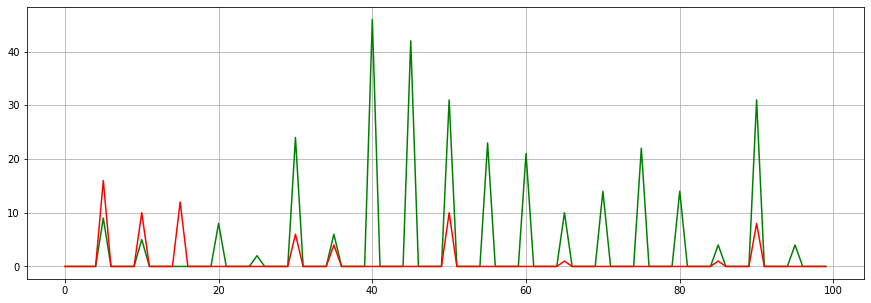

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='+']
  g1 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='++']
  g2 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='+++']

  b = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

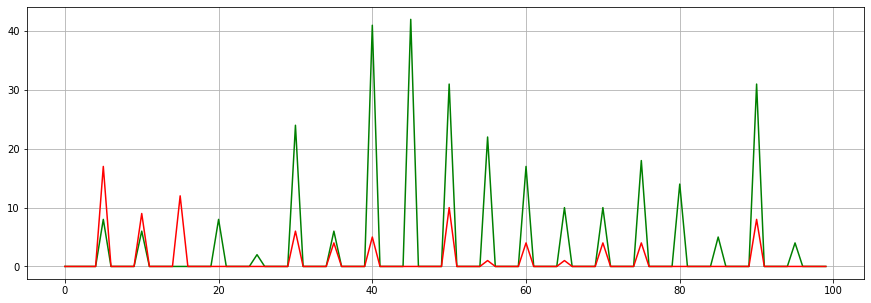

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='+']
  g1 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='++']
  g2 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='+++']

  b = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

In [ ]:
Good_titration=[]
Bad_titration=[]

for i in Pre_shock1:
  if i['% Charge'].iloc[0]==50 and i['Qualité EEG'].iloc[0]=='+++':
    Good_titration.append(i)
  if i['% Charge'].iloc[0]==50 and i['Qualité EEG'].iloc[0]=='-':
    Bad_titration.append(i)  

In [ ]:
print(len(Bad_titration),len(Good_titration))

10 29


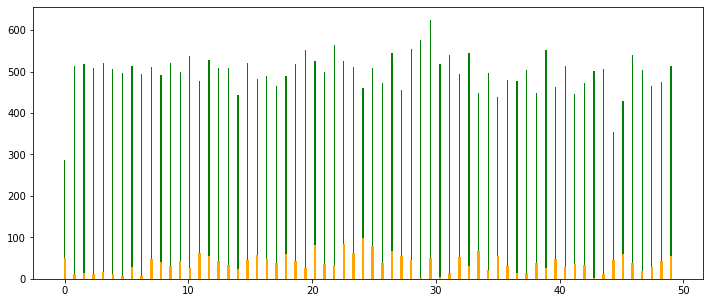

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=2
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG2'].values.astype(float)
y1 = Bad_titration[n]['EEG2'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

2022-05-31

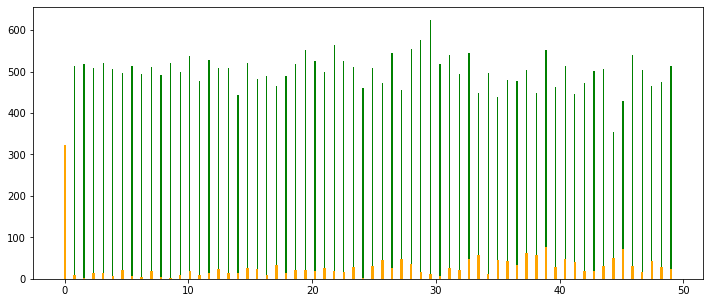

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=2
m=4
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG2'].values.astype(float)
y1 = Bad_titration[m]['EEG2'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

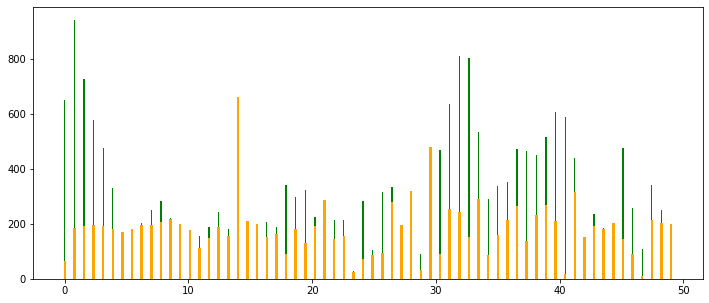

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=7
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG0'].values.astype(float)
y1 = Good_titration[0]['EEG0'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

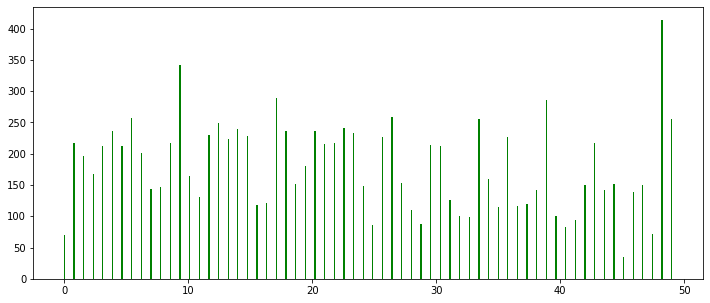

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=1
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG1'].values.astype(float)
# y1 = Good_titration[0]['EEG1'].values.astype(float)
yf = scipy.fftpack.fft(y)
# y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
# ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

In [ ]:
# for n in range(9):
#   y = Bad_titration[n]['EEG1'].values.astype(float)
#   yf = scipy.fftpack.fft(y)
#   print(np.abs(yf[:N//2])[15]/64 )


Dual channel success rate

In [ ]:
# Preshock and postshock seperation and concatenation Dual channel

cols = ['index', 'EEG0', 'EEG1','Post_EEG0', 'Post_EEG1', 'Date', 'Ti vs Tt', 'Site',
       'Phase', '% Charge', 'Durée clinique ', 'Durée EEG', 'Anesthésiant',
       'Qualité clinique', 'Qualité EEG', 'Adranergie',
       'Qualité Aplatissement', 'Patient_id', 'Xls_file_path', 'EEG_file_path']
#=============================================================================================#
Pre_shock2 = [EEGs_Dual_Channel[i].iloc[0:min(EEGs_Dual_Channel[i]['EEG0'].astype(float)[EEGs_Dual_Channel[i]['EEG0'].astype(float) ==EEGs_Dual_Channel[i]['EEG0'].astype(float).max()].index[0],
                                              EEGs_Dual_Channel[i]['EEG1'].astype(float)[EEGs_Dual_Channel[i]['EEG1'].astype(float) ==EEGs_Dual_Channel[i]['EEG1'].astype(float).max()].index[0])].reset_index() for i in range(194)]
Post_shock2 = [EEGs_Dual_Channel[i].iloc[-1000:-1].reset_index() for i in range(194)]
#=============================================================================================#

for i in range(194):
  Pre_shock2[i]['Post_EEG0'] = Post_shock2[i]['EEG0'] 
  Pre_shock2[i]['Post_EEG1'] = Post_shock2[i]['EEG1'] 
  Pre_shock2[i] = Pre_shock2[i].reindex(columns = cols)
  

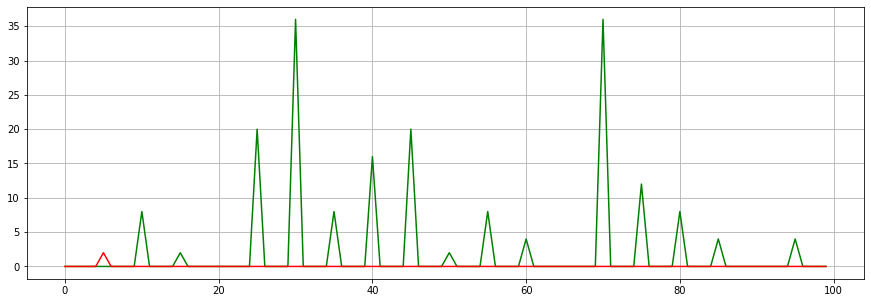

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='+']
  g1 = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='++']
  g2 = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='+++']

  b = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

In [ ]:
Pre_post_shock2 = pd.concat(Pre_shock2, axis=0)

EEGs Concatenation

In [ ]:
Concat_quad0= pd.concat([EEGs_Quad_Channel[i] for i in range(200)], axis=0)[['EEG0','EEG1','EEG2','EEG3','% Charge','Qualité clinique']]
pd.to_pickle(Concat_quad0, 'Concat_quad0.pkl')
del Concat_quad0

In [ ]:
Concat_quad1= pd.concat([EEGs_Quad_Channel[i] for i in range(200,403)], axis=0)[['EEG0','EEG1','EEG2','EEG3','% Charge','Qualité clinique']]
pd.to_pickle(Concat_quad1, 'Concat_quad1.pkl')
del Concat_quad1

In [ ]:
Concat_quad= pd.concat([pd.read_pickle('Concat_quad0.pkl'), pd.read_pickle('Concat_quad1.pkl')], axis=0)

In [ ]:
pd.to_pickle(Concat_quad, 'Concat_quad.pkl')

In [3]:
%cd /content/gdrive/MyDrive/Sajjad_cloned_ready

/content/gdrive/MyDrive/Sajjad_cloned_ready


In [ ]:
ls

CITATION.cff        examples/    model_cards/    README_zh-hans.md  templates/
CODE_OF_CONDUCT.md  hubconf.py   notebooks/      README_zh-hant.md  tests/
conftest.py         ISSUES.md    pyproject.toml  scripts/           utils/
CONTRIBUTING.md     LICENSE      README_es.md    setup.cfg
docker/             Makefile     README_ko.md    setup.py
docs/               MANIFEST.in  README.md       src/


In [ ]:
!cp Concat_quad.pkl /content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad.pkl

In [ ]:
from google.colab import files 
files.upload()

{}

In [4]:
Concat_quad_pkl = pd.read_pickle('Concat_quad.pkl')

Scaling

In [5]:
# In the charge column some of the rows' value is: '5 puis 10' which is not a float so we repalced it by the 10.
Concat_quad_pkl = Concat_quad_pkl.replace('5 puis 10',10)

In [6]:
scale = MinMaxScaler()
Concat_quad_pkl[['EEG0','EEG1','EEG2','EEG3','% Charge']] = scale.fit_transform(Concat_quad_pkl[['EEG0','EEG1','EEG2','EEG3','% Charge']])

In [ ]:
#Saving data to gdrive
pd.to_pickle(Concat_quad_pkl, 'Concat_quad_pkl_scaled.pkl')
!cp 'Concat_quad_pkl_scaled.pkl' /content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad_scaled.pkl

In [6]:
Concat_quad_pkl = pd.read_pickle('/content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad_scaled.pkl')

Label encoding

Dataset and label prepration

In [7]:
Concat_quad_pkl = Concat_quad_pkl.dropna()

In [8]:
# Choosing only the good EEGs
Dataset = Concat_quad_pkl[(Concat_quad_pkl['Qualité clinique']== '+++') | (Concat_quad_pkl['Qualité clinique']== '++')][['EEG0','EEG1','EEG2','EEG3','% Charge']]

In [9]:
# We defined a function to make a dataset with demanded element size

def elementor(df, element_size):
  t0 = df[list(df.columns)[0:-1]].values
  round = int(t0.shape[0]/element_size)
  t0 = t0[0:(round*element_size)]
  return t0.reshape((round, element_size, df.shape[1]-1)), np.array([df[list(df.columns)[-1]].iloc[i*element_size:(i+1)*element_size].mean()  for i in range(round)])

data, label = elementor(Dataset,196)

In [72]:
TrainsetF,TestsetF, LabelFairl, TestLabelFairl=train_test_split(data ,label,test_size=0.33333333)

In [66]:
np.sum(TestLabelFairl)

8392.75349087003

In [73]:
TestLabelFairl.shape

(16491,)

In [12]:
TrainsetF1=TrainsetF.reshape((33146*196*4))

In [13]:
def label(x):
  return int((x*10))
Vlabel=np.vectorize(label) 
Y=Vlabel(TrainsetF1)

In [14]:
from keras import*
from keras.layers import*
embedding_size = 3
model = models.Sequential()
model.add(Embedding(input_dim = TrainsetF.shape[0], output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(257, activation="relu"))
model.add(Dense(10))
model.compile(loss = "mse", optimizer = "adam")
model.fit(x = TrainsetF1, y=Y , epochs = 1, batch_size = 4)

   1196/6496616 [..............................] - ETA: 4:38:59 - loss: 0.9582

KeyboardInterrupt: ignored

#Main

In [19]:
# coding=utf-8
# Copyright 2021 Google Research and The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" PyTorch BigBird model. """


import math
import os
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import Transformer_BigBird


BIG_BIRD_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "google/bigbird-roberta-base",
    "google/bigbird-roberta-large",
    "google/bigbird-base-trivia-itc",
    # See all BigBird models at https://huggingface.co/models?filter=big_bird
]

_TRIVIA_QA_MAPPING = {
    "big_bird_attention": "attention/self",
    "output_layer_norm": "output/LayerNorm",
    "attention_output": "attention/output/dense",
    "output": "output/dense",
    "self_attention_layer_norm": "attention/output/LayerNorm",
    "intermediate": "intermediate/dense",
    "word_embeddings": "bert/embeddings/word_embeddings",
    "position_embedding": "bert/embeddings/position_embeddings",
    "type_embeddings": "bert/embeddings/token_type_embeddings",
    "embeddings": "bert/embeddings",
    "layer_normalization": "output/LayerNorm",
    "layer_norm": "LayerNorm",
    "trivia_qa_head": "qa_classifier",
    "dense": "intermediate/dense",
    "dense_1": "qa_outputs",
}


config='big_bird'
def load_tf_weights_in_big_bird(model, tf_checkpoint_path, is_trivia_qa=False):
    """Load tf checkpoints in a pytorch model."""

    def load_tf_weights_bert(init_vars, tf_path):
        names = []
        tf_weights = {}

        for name, shape in init_vars:
            array = tf.train.load_variable(tf_path, name)
            name = name.replace("bert/encoder/LayerNorm", "bert/embeddings/LayerNorm")
            logger.info(f"Loading TF weight {name} with shape {shape}")
            names.append(name)
            tf_weights[name] = array

        return names, tf_weights

    def load_tf_weights_trivia_qa(init_vars):
        names = []
        tf_weights = {}

        for i, var in enumerate(init_vars):
            name_items = var.name.split("/")

            if "transformer_scaffold" in name_items[0]:
                layer_name_items = name_items[0].split("_")
                if len(layer_name_items) < 3:
                    layer_name_items += [0]

                name_items[0] = f"bert/encoder/layer_{layer_name_items[2]}"

            name = "/".join([_TRIVIA_QA_MAPPING[x] if x in _TRIVIA_QA_MAPPING else x for x in name_items])[
                :-2
            ]  # remove last :0 in variable

            if "self/attention/output" in name:
                name = name.replace("self/attention/output", "output")

            if i >= len(init_vars) - 2:
                name = name.replace("intermediate", "output")

            logger.info(f"Loading TF weight {name} with shape {var.shape}")
            array = var.value().numpy()
            names.append(name)
            tf_weights[name] = array

        return names, tf_weights

    try:
        import re

        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info(f"Converting TensorFlow checkpoint from {tf_path}")

    # Load weights from TF model
    init_vars = tf.saved_model.load(tf_path).variables if is_trivia_qa else tf.train.list_variables(tf_path)

    assert len(init_vars) > 0, "Loaded trained variables cannot be empty."

    pt_names = list(model.state_dict().keys())

    if is_trivia_qa:
        names, tf_weights = load_tf_weights_trivia_qa(init_vars)
    else:
        names, tf_weights = load_tf_weights_bert(init_vars, tf_path)

    for txt_name in names:
        array = tf_weights[txt_name]
        name = txt_name.split("/")
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ):
            logger.info(f"Skipping {'/'.join(name)}")
            continue
        pointer = model
        pt_name = []
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+_\d+", m_name):
                scope_names = re.split(r"_(\d+)", m_name)
            else:
                scope_names = [m_name]
            if scope_names[0] == "kernel" or scope_names[0] == "gamma":
                pointer = getattr(pointer, "weight")
                pt_name.append("weight")
            elif scope_names[0] == "output_bias" or scope_names[0] == "beta":
                pointer = getattr(pointer, "bias")
                pt_name.append("bias")
            elif scope_names[0] == "output_weights":
                pointer = getattr(pointer, "weight")
                pt_name.append("weight")
            elif scope_names[0] == "squad":
                pointer = getattr(pointer, "classifier")
                pt_name.append("classifier")
            elif scope_names[0] == "transform":
                pointer = getattr(pointer, "transform")
                pt_name.append("transform")
                if ("bias" in name) or ("kernel" in name):
                    pointer = getattr(pointer, "dense")
                    pt_name.append("dense")
                elif ("beta" in name) or ("gamma" in name):
                    pointer = getattr(pointer, "LayerNorm")
                    pt_name.append("LayerNorm")
            else:
                try:
                    pointer = getattr(pointer, scope_names[0])
                    pt_name.append(f"{scope_names[0]}")
                except AttributeError:
                    logger.info(f"Skipping {m_name}")
                    continue
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]
                pt_name.append(f"{num}")
        if m_name[-11:] == "_embeddings" or m_name == "embeddings":
            pointer = getattr(pointer, "weight")
            pt_name.append("weight")
        elif m_name == "kernel":
            array = np.transpose(array)
        try:
            if len(array.shape) > len(pointer.shape) and math.prod(array.shape) == math.prod(pointer.shape):
                # print(txt_name, array.shape)
                if (
                    txt_name.endswith("attention/self/key/kernel")
                    or txt_name.endswith("attention/self/query/kernel")
                    or txt_name.endswith("attention/self/value/kernel")
                ):
                    array = array.transpose(1, 0, 2).reshape(pointer.shape)
                elif txt_name.endswith("attention/output/dense/kernel"):
                    array = array.transpose(0, 2, 1).reshape(pointer.shape)
                else:
                    array = array.reshape(pointer.shape)

            if pointer.shape != array.shape:
                raise ValueError(
                    f"Pointer shape {pointer.shape} and array shape {array.shape} mismatched of {txt_name}."
                )
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        pt_weight_name = ".".join(pt_name)
        logger.info(f"Initialize PyTorch weight {pt_weight_name} from {txt_name}.")
        pointer.data = torch.from_numpy(array)
        tf_weights.pop(txt_name, None)
        pt_names.remove(pt_weight_name)

    logger.info(f"Weights not copied to PyTorch model: {', '.join(tf_weights.keys())}.")
    logger.info(f"Weights not initialized in PyTorch model: {', '.join(pt_names)}.")
    return model


class BigBirdEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    # Copied from transformers.models.bert.modeling_bert.BertEmbeddings.__init__
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        # End copy

        self.rescale_embeddings = config.rescale_embeddings
        self.hidden_size = config.hidden_size

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        if self.rescale_embeddings:
            inputs_embeds = inputs_embeds * (self.hidden_size ** 0.5)

        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings

        position_embeddings = self.position_embeddings(position_ids)
        embeddings += position_embeddings

        embeddings = self.dropout(embeddings)
        embeddings = self.LayerNorm(embeddings)
        return embeddings


class BigBirdSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)
        self.key = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)
        self.value = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BigBirdModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = F.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


class BigBirdBlockSparseAttention(nn.Module):
    def __init__(self, config, seed=None):
        super().__init__()

        self.max_seqlen = config.max_position_embeddings
        self.seed = seed

        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size {config.hidden_size} is not a multiple of the number of attention "
                f"heads {config.num_attention_heads}."
            )

        self.num_attention_heads = config.num_attention_heads
        self.num_random_blocks = config.num_random_blocks
        self.block_size = config.block_size

        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)
        self.key = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)
        self.value = nn.Linear(config.hidden_size, self.all_head_size, bias=config.use_bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        band_mask=None,
        from_mask=None,
        to_mask=None,
        from_blocked_mask=None,
        to_blocked_mask=None,
        output_attentions=None,
    ):
        # Currently this `class` can't be used in decoder.

        batch_size, seqlen, _ = hidden_states.size()
        to_seq_length = from_seq_length = seqlen
        from_block_size = to_block_size = self.block_size

        assert from_seq_length % from_block_size == 0, "Query sided sequence length must be multiple of block size"
        assert to_seq_length % to_block_size == 0, "Key/Value sided sequence length must be multiple of block size"

        query_layer = self.transpose_for_scores(self.query(hidden_states))
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        context_layer, attention_probs = self.bigbird_block_sparse_attention(
            query_layer,
            key_layer,
            value_layer,
            band_mask,
            from_mask,
            to_mask,
            from_blocked_mask,
            to_blocked_mask,
            self.num_attention_heads,
            self.num_random_blocks,
            self.attention_head_size,
            from_block_size,
            to_block_size,
            batch_size,
            from_seq_length,
            to_seq_length,
            seed=self.seed,
            plan_from_length=None,
            plan_num_rand_blocks=None,
            output_attentions=output_attentions,
        )

        context_layer = context_layer.contiguous().view(batch_size, from_seq_length, -1)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs

    @staticmethod
    def torch_bmm_nd(inp_1, inp_2, ndim=None):
        """Fast nd matrix multiplication"""
        # faster replacement of torch.einsum ("bhqk,bhkd->bhqd")
        return torch.bmm(inp_1.reshape((-1,) + inp_1.shape[-2:]), inp_2.reshape((-1,) + inp_2.shape[-2:])).view(
            inp_1.shape[: ndim - 2] + (inp_1.shape[ndim - 2], inp_2.shape[ndim - 1])
        )

    @staticmethod
    def torch_bmm_nd_transpose(inp_1, inp_2, ndim=None):
        """Fast nd matrix multiplication with transpose"""
        # faster replacement of torch.einsum (bhqd,bhkd->bhqk)
        return torch.bmm(
            inp_1.reshape((-1,) + inp_1.shape[-2:]), inp_2.reshape((-1,) + inp_2.shape[-2:]).transpose(1, 2)
        ).view(inp_1.shape[: ndim - 2] + (inp_1.shape[ndim - 2], inp_2.shape[ndim - 2]))

    def bigbird_block_sparse_attention(
        self,
        query_layer,
        key_layer,
        value_layer,
        band_mask,
        from_mask,
        to_mask,
        from_blocked_mask,
        to_blocked_mask,
        n_heads,
        n_rand_blocks,
        attention_head_size,
        from_block_size,
        to_block_size,
        batch_size,
        from_seq_len,
        to_seq_len,
        seed,
        plan_from_length,
        plan_num_rand_blocks,
        output_attentions,
    ):

        # BigBird block-sparse attention as suggested in paper

        # ITC:
        #     global tokens: 2 x block_size
        #     window tokens: 3 x block_size
        #     random tokens: num_rand_tokens x block_size

        # ETC:
        #     global tokens: extra_globals_tokens + 2 x block_size
        #     window tokens: 3 x block_size
        #     random tokens: num_rand_tokens x block_size

        # Note:
        #     1) Currently, ETC is not supported.
        #     2) Window size is fixed to 3 blocks & it can be changed only by
        #     changing `block_size`.
        #     3) Number of global blocks are fixed (2 blocks here) & global tokens can be
        #     controlled only by `block_size`.

        # attention is calculated separately for q[0], q[1], q[2:-2], q[-2], q[-1] in order to use special trick of shifting tokens (for calculating sliding attention)
        # hence following code can be divided into 5 parts.

        if from_seq_len // from_block_size != to_seq_len // to_block_size:
            raise ValueError("Error the number of blocks needs to be same!")

        rsqrt_d = 1 / math.sqrt(attention_head_size)
        bsz = batch_size

        # generate random attention and corresponding masks
        np.random.seed(seed)
        if from_seq_len in [1024, 3072, 4096]:  # old plans used in paper
            rand_attn = [
                self._bigbird_block_rand_mask(
                    self.max_seqlen, self.max_seqlen, from_block_size, to_block_size, n_rand_blocks, last_idx=1024
                )[: (from_seq_len // from_block_size - 2)]
                for _ in range(n_heads)
            ]
        else:
            if plan_from_length is None:
                plan_from_length, plan_num_rand_blocks = self._get_rand_attn_plan(
                    from_seq_len, from_block_size, n_rand_blocks
                )

            rand_attn = self._bigbird_block_rand_mask_with_head(
                from_seq_length=from_seq_len,
                to_seq_length=to_seq_len,
                from_block_size=from_block_size,
                to_block_size=to_block_size,
                num_heads=n_heads,
                plan_from_length=plan_from_length,
                plan_num_rand_blocks=plan_num_rand_blocks,
            )

        rand_attn = np.stack(rand_attn, axis=0)
        rand_attn = torch.tensor(rand_attn, device=query_layer.device, dtype=torch.long)
        rand_attn.unsqueeze_(0)
        rand_attn = torch.cat([rand_attn for _ in range(batch_size)], dim=0)

        rand_mask = self._create_rand_mask_from_inputs(
            from_blocked_mask, to_blocked_mask, rand_attn, n_heads, n_rand_blocks, bsz, from_seq_len, from_block_size
        )

        blocked_query_matrix = query_layer.view(bsz, n_heads, from_seq_len // from_block_size, from_block_size, -1)
        blocked_key_matrix = key_layer.view(bsz, n_heads, to_seq_len // to_block_size, to_block_size, -1)
        blocked_value_matrix = value_layer.view(bsz, n_heads, to_seq_len // to_block_size, to_block_size, -1)

        # preparing block for randn attn
        gathered_key = self.torch_gather_b2(blocked_key_matrix, rand_attn)
        gathered_key = gathered_key.view(
            bsz, n_heads, to_seq_len // to_block_size - 2, n_rand_blocks * to_block_size, -1
        )  # [bsz, n_heads, to_seq_len//to_block_size-2, n_rand_blocks, to_block_size, -1]
        gathered_value = self.torch_gather_b2(blocked_value_matrix, rand_attn)
        gathered_value = gathered_value.view(
            bsz, n_heads, to_seq_len // to_block_size - 2, n_rand_blocks * to_block_size, -1
        )  # [bsz, n_heads, to_seq_len//to_block_size-2, n_rand_blocks, to_block_size, -1]

        # 1st PART
        # 1st block (global block) attention scores
        # q[0] x (k[0], k[1], k[2], k[3], k[4] .... )

        # [bsz, n_heads, from_block_size, -1] x [bsz, n_heads, to_seq_len, -1] ==> [bsz, n_heads, from_block_size, to_seq_len]
        first_product = self.torch_bmm_nd_transpose(blocked_query_matrix[:, :, 0], key_layer, ndim=4)

        first_product = first_product * rsqrt_d
        first_product += (1.0 - to_mask) * -10000.0
        first_attn_weights = F.softmax(first_product, dim=-1)  # [bsz, n_heads, from_block_size, to_seq_len]

        # [bsz, n_heads, from_block_size, to_seq_len] x [bsz, n_heads, to_seq_len, -1] ==> [bsz, n_heads, from_block_size, -1]
        first_context_layer = self.torch_bmm_nd(first_attn_weights, value_layer, ndim=4)
        first_context_layer.unsqueeze_(2)

        # 2nd PART
        # 2nd block attention scores
        # q[1] x (sliding_keys, random_keys, global_keys)
        # sliding key blocks -> 2nd, 3rd blocks
        # global key blocks -> 1st block

        second_key_mat = torch.cat(
            [
                blocked_key_matrix[:, :, 0],
                blocked_key_matrix[:, :, 1],
                blocked_key_matrix[:, :, 2],
                blocked_key_matrix[:, :, -1],
                gathered_key[:, :, 0],
            ],
            dim=2,
        )  # [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1]
        second_value_mat = torch.cat(
            [
                blocked_value_matrix[:, :, 0],
                blocked_value_matrix[:, :, 1],
                blocked_value_matrix[:, :, 2],
                blocked_value_matrix[:, :, -1],
                gathered_value[:, :, 0],
            ],
            dim=2,
        )  # [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1]

        # [bsz, n_heads, from_block_size, -1] x [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1] ==> [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size]
        second_product = self.torch_bmm_nd_transpose(blocked_query_matrix[:, :, 1], second_key_mat, ndim=4)
        second_seq_pad = torch.cat(
            [
                to_mask[:, :, :, : 3 * to_block_size],
                to_mask[:, :, :, -to_block_size:],
                first_context_layer.new_ones([bsz, 1, 1, n_rand_blocks * to_block_size]),
            ],
            dim=3,
        )
        second_rand_pad = torch.cat(
            [
                first_context_layer.new_ones([bsz, n_heads, from_block_size, 4 * to_block_size]),
                rand_mask[:, :, 0],
            ],
            dim=3,
        )
        second_product = second_product * rsqrt_d
        second_product += (1.0 - torch.minimum(second_seq_pad, second_rand_pad)) * -10000.0
        second_attn_weights = F.softmax(
            second_product, dim=-1
        )  # [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size]

        # [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size] x [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1] ==> [bsz, n_heads, from_block_size, -1]
        second_context_layer = self.torch_bmm_nd(second_attn_weights, second_value_mat, ndim=4)

        second_context_layer.unsqueeze_(2)

        # 3rd PART
        # Middle blocks attention scores
        # q[-2:2] x (sliding_keys, random_keys, global_keys)
        # sliding attn is calculated using special trick of shifting tokens as discussed in paper
        # random keys are generated by taking random indices as per `rand_attn`
        # global keys -> 1st & last block

        exp_blocked_key_matrix = torch.cat(
            [blocked_key_matrix[:, :, 1:-3], blocked_key_matrix[:, :, 2:-2], blocked_key_matrix[:, :, 3:-1]], dim=3
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, 3*to_block_size, -1]
        exp_blocked_value_matrix = torch.cat(
            [blocked_value_matrix[:, :, 1:-3], blocked_value_matrix[:, :, 2:-2], blocked_value_matrix[:, :, 3:-1]],
            dim=3,
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, 3*to_block_size, -1]
        middle_query_matrix = blocked_query_matrix[:, :, 2:-2]

        # sliding attention scores for q[-2:2]
        # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1] x [b, n_heads, from_seq_len//from_block_size-4, 3*to_block_size, -1]
        inner_band_product = self.torch_bmm_nd_transpose(middle_query_matrix, exp_blocked_key_matrix, ndim=5)
        #     ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, 3*to_block_size]
        inner_band_product = inner_band_product * rsqrt_d

        # randn attention scores for q[-2:2]
        # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1] x [bsz, n_heads, from_seq_len//from_block_size-4, n_rand_blocks*to_block_size, -1]
        rand_band_product = self.torch_bmm_nd_transpose(middle_query_matrix, gathered_key[:, :, 1:-1], ndim=5)
        #     ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, n_rand_blocks*to_block_size]
        rand_band_product = rand_band_product * rsqrt_d

        # Including 1st block (since it's global)
        first_band_product = torch.einsum(
            "bhlqd,bhkd->bhlqk", middle_query_matrix, blocked_key_matrix[:, :, 0]
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1] x [bsz, n_heads, to_block_size, -1] ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, to_block_size]
        first_band_product = first_band_product * rsqrt_d

        # Including last block (since it's global)
        last_band_product = torch.einsum(
            "bhlqd,bhkd->bhlqk", middle_query_matrix, blocked_key_matrix[:, :, -1]
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1] x [bsz, n_heads, to_block_size, -1] ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, to_block_size]
        last_band_product = last_band_product * rsqrt_d

        # masking padded tokens
        inner_band_product += (1.0 - band_mask) * -10000.0
        first_band_product += (1.0 - to_mask[:, :, :, :to_block_size].unsqueeze(3)) * -10000.0
        last_band_product += (1.0 - to_mask[:, :, :, -to_block_size:].unsqueeze(3)) * -10000.0
        rand_band_product += (1.0 - rand_mask[:, :, 1:-1]) * -10000.0

        # completing attention scores matrix for all q[-2:2]
        band_product = torch.cat(
            [first_band_product, inner_band_product, rand_band_product, last_band_product], dim=-1
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, (5+n_rand_blocks)*to_block_size]

        # safely doing softmax since attention matrix is completed
        attn_weights = F.softmax(
            band_product, dim=-1
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, (5+n_rand_blocks)*to_block_size]

        # contribution of sliding keys
        # [bsz, n_heads, m//from_block_size-4, from_block_size, 3*to_block_size] x [bsz, n_heads, from_seq_len//from_block_size-4, 3*to_block_size, -1]
        context_layer = self.torch_bmm_nd(
            attn_weights[:, :, :, :, to_block_size : 4 * to_block_size], exp_blocked_value_matrix, ndim=5
        )
        #     ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1]

        # adding contribution of random keys
        # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, n_rand_blocks*to_block_size] x [bsz, n_heads, from_seq_len//from_block_size-4, n_rand_blocks*to_block_size, -1]
        context_layer += self.torch_bmm_nd(
            attn_weights[:, :, :, :, 4 * to_block_size : -to_block_size], gathered_value[:, :, 1:-1], ndim=5
        )
        #     ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1]

        # adding contribution of global keys
        context_layer += torch.einsum(
            "bhlqk,bhkd->bhlqd", attn_weights[:, :, :, :, :to_block_size], blocked_value_matrix[:, :, 0]
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, to_block_size] x [bsz, n_heads, to_block_size, -1] ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1]
        context_layer += torch.einsum(
            "bhlqk,bhkd->bhlqd", attn_weights[:, :, :, :, -to_block_size:], blocked_value_matrix[:, :, -1]
        )  # [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, to_block_size] x [bsz, n_heads, to_block_size, -1] ==> [bsz, n_heads, from_seq_len//from_block_size-4, from_block_size, -1]

        # 4th PART
        # last 2nd token attention scores
        # q[-2] x (sliding_keys, random_keys, global_keys)
        # sliding key blocks -> last 3 blocks
        # global key block -> 1st block
        # random key block -> based on indices stored in `randn_attn`

        second_last_key_mat = torch.cat(
            [
                blocked_key_matrix[:, :, 0],
                blocked_key_matrix[:, :, -3],
                blocked_key_matrix[:, :, -2],
                blocked_key_matrix[:, :, -1],
                gathered_key[:, :, -1],
            ],
            dim=2,
        )  # [bsz, n_heads, (4+n_random_blocks)*to_block_size, -1]
        second_last_value_mat = torch.cat(
            [
                blocked_value_matrix[:, :, 0],
                blocked_value_matrix[:, :, -3],
                blocked_value_matrix[:, :, -2],
                blocked_value_matrix[:, :, -1],
                gathered_value[:, :, -1],
            ],
            dim=2,
        )  # [bsz, n_heads, (4+r)*to_block_size, -1]

        # [bsz, n_heads, from_block_size, -1] x [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1] ==> [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size]
        second_last_product = self.torch_bmm_nd_transpose(blocked_query_matrix[:, :, -2], second_last_key_mat, ndim=4)
        second_last_seq_pad = torch.cat(
            [
                to_mask[:, :, :, :to_block_size],
                to_mask[:, :, :, -3 * to_block_size :],
                context_layer.new_ones([bsz, 1, 1, n_rand_blocks * to_block_size]),
            ],
            dim=3,
        )
        second_last_rand_pad = torch.cat(
            [
                context_layer.new_ones([bsz, n_heads, from_block_size, 4 * to_block_size]),
                rand_mask[:, :, -1],
            ],
            dim=3,
        )
        second_last_product = second_last_product * rsqrt_d
        second_last_product += (1.0 - torch.minimum(second_last_seq_pad, second_last_rand_pad)) * -10000.0
        second_last_attn_weights = F.softmax(
            second_last_product, dim=-1
        )  # [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size]

        # [bsz, n_heads, from_block_size, (4+n_rand_blocks)*to_block_size] x [bsz, n_heads, (4+n_rand_blocks)*to_block_size, -1] ==> [bsz, n_heads, from_block_size, -1]
        second_last_context_layer = self.torch_bmm_nd(second_last_attn_weights, second_last_value_mat, ndim=4)
        second_last_context_layer.unsqueeze_(2)

        # 5th PART
        # last block (global) attention scores
        # q[-1] x (k[0], k[1], k[2], k[3], .... )

        # [bsz, n_heads, from_block_size, -1] x [bsz, n_heads, to_seq_len, -1] ==> [bsz, n_heads, from_block_size, to_seq_len]
        last_product = self.torch_bmm_nd_transpose(blocked_query_matrix[:, :, -1], key_layer, ndim=4)
        last_product = last_product * rsqrt_d
        last_product += (1.0 - to_mask) * -10000.0
        last_attn_weights = F.softmax(last_product, dim=-1)  # [bsz, n_heads, from_block_size, n]

        # [bsz, n_heads, from_block_size, to_seq_len] x [bsz, n_heads, to_seq_len, -1] ==> [bsz, n_heads, from_block_size, -1]
        last_context_layer = self.torch_bmm_nd(last_attn_weights, value_layer, ndim=4)
        last_context_layer.unsqueeze_(2)

        # combining representations of all tokens
        context_layer = torch.cat(
            [first_context_layer, second_context_layer, context_layer, second_last_context_layer, last_context_layer],
            dim=2,
        )
        context_layer = context_layer.view((bsz, n_heads, from_seq_len, -1)) * from_mask
        context_layer = torch.transpose(context_layer, 1, 2)

        # this is just for visualizing; forward pass doesn't depend on following code
        if output_attentions:
            # TODO(PVP): need to verify if below code is correct
            attention_probs = torch.zeros(
                bsz, n_heads, from_seq_len, to_seq_len, dtype=torch.float, device=context_layer.device
            )

            # 1st query block
            # corresponding to `first_context_layer`
            attention_probs[:, :, :from_block_size, :] = first_attn_weights  # all keys global

            # 2nd query block
            # corresponding to `second_context_layer`
            attention_probs[:, :, from_block_size : 2 * from_block_size, : 3 * to_block_size] = second_attn_weights[
                :, :, :, : 3 * to_block_size
            ]  # 1st three key blocks (global + sliding)
            attention_probs[:, :, from_block_size : 2 * from_block_size, -to_block_size:] = second_attn_weights[
                :, :, :, 3 * to_block_size : 4 * to_block_size
            ]  # last key block (global)
            # random keys
            for p1, i1, w1 in zip(range(bsz), rand_attn, second_attn_weights):
                # p1, i1, w1 corresponds to batch_dim i.e. following operation is done for each sequence in batch
                for p2, i2, w2 in zip(range(n_heads), i1, w1):
                    # p2, i2, w2 corresponds to head_dim i.e. following operation is done for each heads
                    attn_probs_view = attention_probs.view(
                        bsz,
                        n_heads,
                        from_seq_len // from_block_size,
                        from_block_size,
                        to_seq_len // to_block_size,
                        to_block_size,
                    )
                    right_slice = w2[:, 4 * to_block_size :]
                    attn_probs_view[p1, p2, 1, :, i2[0]] = right_slice.view(
                        from_block_size, n_rand_blocks, to_block_size
                    )

            # Middle query blocks
            # corresponding to `context_layer`
            # sliding keys
            for q_idx in range(from_seq_len // from_block_size - 4):
                attn_probs_view = attention_probs.view(
                    bsz,
                    n_heads,
                    from_seq_len // from_block_size,
                    from_block_size,
                    to_seq_len // to_block_size,
                    to_block_size,
                )[:, :, 2:-2, :, 1:-1, :]
                right_slice = attn_weights[:, :, q_idx, :, to_block_size : 4 * to_block_size]
                attn_probs_view[:, :, q_idx, :, q_idx : q_idx + 3, :] = right_slice.view(
                    bsz, n_heads, from_block_size, 3, to_block_size
                )  # inner_band_product
            # global keys (corresponding to 1st key block)
            attention_probs[:, :, 2 * from_block_size : -2 * from_block_size, :to_block_size] = attn_weights[
                :, :, :, :, :to_block_size
            ].view(
                bsz, n_heads, -1, to_block_size
            )  # first_band_product
            # global keys (corresponding to last key block)
            attention_probs[:, :, 2 * from_block_size : -2 * from_block_size, -to_block_size:] = attn_weights[
                :, :, :, :, -to_block_size:
            ].view(
                bsz, n_heads, -1, to_block_size
            )  # last_band_product
            # random keys
            for p1, i1, w1 in zip(range(bsz), rand_attn, attn_weights):
                # p1, i1, w1 corresponds to batch_dim i.e. following operation is done for each sequence in batch
                for p2, i2, w2 in zip(range(n_heads), i1, w1):
                    # p2, i2, w2 corresponds to head_dim i.e. following operation is done for each heads
                    for q_idx in range(1, len(i2) - 1):
                        attn_probs_view = attention_probs.view(
                            bsz,
                            n_heads,
                            from_seq_len // from_block_size,
                            from_block_size,
                            to_seq_len // to_block_size,
                            to_block_size,
                        )
                        right_slice = w2[q_idx - 1, :, 4 * to_block_size : -to_block_size]
                        attn_probs_view[p1, p2, q_idx + 1, :, i2[q_idx]] = right_slice.view(
                            from_block_size, n_rand_blocks, to_block_size
                        )

            # Second-last query block
            # corresponding to `second_last_context_layer`
            attention_probs[:, :, -2 * from_block_size : -from_block_size, :to_block_size] = second_last_attn_weights[
                :, :, :, :to_block_size
            ]  # 1st key block (global)
            attention_probs[
                :, :, -2 * from_block_size : -from_block_size, -3 * to_block_size :
            ] = second_last_attn_weights[
                :, :, :, to_block_size : 4 * to_block_size
            ]  # last three blocks (global + sliding)
            # random keys
            for p1, i1, w1 in zip(range(bsz), rand_attn, second_last_attn_weights):
                # p1, i1, w1 corresponds to batch_dim i.e. following operation is done for each sequence in batch
                for p2, i2, w2 in zip(range(n_heads), i1, w1):
                    # p2, i2, w2 corresponds to head_dim i.e. following operation is done for each heads
                    attn_probs_view = attention_probs.view(
                        bsz,
                        n_heads,
                        from_seq_len // from_block_size,
                        from_block_size,
                        to_seq_len // to_block_size,
                        to_block_size,
                    )
                    right_slice = w2[:, 4 * to_block_size :]
                    attn_probs_view[p1, p2, -2, :, i2[-1]] = right_slice.view(
                        from_block_size, n_rand_blocks, to_block_size
                    )

            # last query block
            # corresponding to `last_context_layer`
            attention_probs[:, :, -from_block_size:, :] = last_attn_weights  # all keys global

        else:
            attention_probs = None

        return context_layer, attention_probs

    @staticmethod
    def torch_gather_b2(params, indices):
        # this operation is equivalent to tf.gather when batch_dims=2

        if params.shape[:2] != indices.shape[:2]:
            raise ValueError(
                f"Make sure that the first two dimensions of params and indices are identical, \
                but they are params: {params.shape[:2]} vs. indices: {params.shape[:2]}"
            )
        num_indices_to_gather = indices.shape[-2] * indices.shape[-1]
        num_indices_to_pick_from = params.shape[2]

        indices_shift = (
            torch.arange(indices.shape[0] * indices.shape[1] * num_indices_to_gather, device=indices.device)
            // num_indices_to_gather
            * num_indices_to_pick_from
        )

        flattened_indices = indices.view(-1) + indices_shift
        flattened_params = params.reshape(-1, params.shape[-2], params.shape[-1])

        out_flattened = flattened_params.index_select(0, flattened_indices)

        out = out_flattened.reshape(params.shape[:2] + (num_indices_to_gather,) + params.shape[3:])
        return out

    @staticmethod
    def _create_rand_mask_from_inputs(
        from_blocked_mask,
        to_blocked_mask,
        rand_attn,
        num_attention_heads,
        num_rand_blocks,
        batch_size,
        from_seq_length,
        from_block_size,
    ):
        """
        Create 3D attention mask from a 2D tensor mask.

        Args:
            from_blocked_mask: 2D Tensor of shape [batch_size,
            from_seq_length//from_block_size, from_block_size].
            to_blocked_mask: int32 Tensor of shape [batch_size,
            to_seq_length//to_block_size, to_block_size].
            rand_attn: [batch_size, num_attention_heads,
            from_seq_length//from_block_size-2, num_rand_blocks]
            num_attention_heads: int. Number of attention heads.
            num_rand_blocks: int. Number of random chunks per row.
            batch_size: int. Batch size for computation.
            from_seq_length: int. length of from sequence.
            from_block_size: int. size of block in from sequence.

        Returns:
            float Tensor of shape [batch_size, num_attention_heads, from_seq_length//from_block_size-2,
            from_block_size, num_rand_blocks*to_block_size].
        """
        num_windows = from_seq_length // from_block_size - 2
        rand_mask = torch.stack([p1[i1.flatten()] for p1, i1 in zip(to_blocked_mask, rand_attn)])
        rand_mask = rand_mask.view(batch_size, num_attention_heads, num_windows, num_rand_blocks * from_block_size)
        rand_mask = torch.einsum("blq,bhlk->bhlqk", from_blocked_mask[:, 1:-1], rand_mask)
        return rand_mask

    @staticmethod
    def _get_rand_attn_plan(from_seq_length, from_block_size, num_rand_blocks):
        """
        Gives the plan of where to put random attention.

        Args:
            from_seq_length: int. length of from sequence.
            from_block_size: int. size of block in from sequence.
            num_rand_blocks: int. Number of random chunks per row.

        Returns:
            plan_from_length: ending location of from block plan_num_rand_blocks: number of random ending location for
            each block
        """

        plan_from_length = []
        plan_num_rand_blocks = []
        if (2 * num_rand_blocks + 5) < (from_seq_length // from_block_size):
            plan_from_length.append(int((2 * num_rand_blocks + 5) * from_block_size))
            plan_num_rand_blocks.append(num_rand_blocks)
            plan_from_length.append(from_seq_length)
            plan_num_rand_blocks.append(0)
        elif (num_rand_blocks + 5) < (from_seq_length // from_block_size):
            plan_from_length.append(int((num_rand_blocks + 5) * from_block_size))
            plan_num_rand_blocks.append(num_rand_blocks // 2)
            plan_from_length.append(from_seq_length)
            plan_num_rand_blocks.append(num_rand_blocks - (num_rand_blocks // 2))
        else:
            plan_from_length.append(from_seq_length)
            plan_num_rand_blocks.append(num_rand_blocks)

        return plan_from_length, plan_num_rand_blocks

    @staticmethod
    def _bigbird_block_rand_mask(
        from_seq_length, to_seq_length, from_block_size, to_block_size, num_rand_blocks, last_idx=-1
    ):
        """
        Create adjacency list of random attention.

        Args:
            from_seq_length: int. length of from sequence.
            to_seq_length: int. length of to sequence.
            from_block_size: int. size of block in from sequence.
            to_block_size: int. size of block in to sequence.
            num_rand_blocks: int. Number of random chunks per row.
            last_idx: if -1 then num_rand_blocks blocks chosen anywhere in to sequence,
            if positive then num_rand_blocks blocks chosen only up to last_idx.

        Returns:
            adjacency list of size from_seq_length//from_block_size-2 by num_rand_blocks
        """
        # using this method when from_seq_length in [1024, 3072, 4096]

        assert (
            from_seq_length // from_block_size == to_seq_length // to_block_size
        ), "Error the number of blocks needs to be same!"

        rand_attn = np.zeros((from_seq_length // from_block_size - 2, num_rand_blocks), dtype=np.int32)
        middle_seq = np.arange(1, to_seq_length // to_block_size - 1, dtype=np.int32)
        last = to_seq_length // to_block_size - 1
        if last_idx > (2 * to_block_size):
            last = (last_idx // to_block_size) - 1

        r = num_rand_blocks  # shorthand
        for i in range(1, from_seq_length // from_block_size - 1):
            start = i - 2
            end = i
            if i == 1:
                rand_attn[i - 1, :] = np.random.permutation(middle_seq[2:last])[:r]
            elif i == 2:
                rand_attn[i - 1, :] = np.random.permutation(middle_seq[3:last])[:r]
            elif i == from_seq_length // from_block_size - 3:
                rand_attn[i - 1, :] = np.random.permutation(middle_seq[:last])[:r]
            # Missing -3: should have been sliced till last-3
            elif i == from_seq_length // from_block_size - 2:
                rand_attn[i - 1, :] = np.random.permutation(middle_seq[:last])[:r]
            # Missing -4: should have been sliced till last-4
            else:
                if start > last:
                    start = last
                    rand_attn[i - 1, :] = np.random.permutation(middle_seq[:start])[:r]
                elif (end + 1) == last:
                    rand_attn[i - 1, :] = np.random.permutation(middle_seq[:start])[:r]
                else:
                    rand_attn[i - 1, :] = np.random.permutation(
                        np.concatenate((middle_seq[:start], middle_seq[end + 1 : last]))
                    )[:r]
        return rand_attn

    def _bigbird_block_rand_mask_with_head(
        self,
        from_seq_length,
        to_seq_length,
        from_block_size,
        to_block_size,
        num_heads,
        plan_from_length,
        plan_num_rand_blocks,
        window_block_left=1,
        window_block_right=1,
        global_block_top=1,
        global_block_bottom=1,
        global_block_left=1,
        global_block_right=1,
    ):
        """
        Create adjacency list of random attention.

        Args:
            from_seq_length: int. length of from sequence.
            to_seq_length: int. length of to sequence.
            from_block_size: int. size of block in from sequence.
            to_block_size: int. size of block in to sequence.
            num_heads: int. total number of heads.
            plan_from_length: list. plan from length where num_random_blocks are choosen from.
            plan_num_rand_blocks: list. number of rand blocks within the plan.
            window_block_left: int. number of blocks of window to left of a block.
            window_block_right: int. number of blocks of window to right of a block.
            global_block_top: int. number of blocks at the top.
            global_block_bottom: int. number of blocks at the bottom.
            global_block_left: int. Number of blocks globally used to the left.
            global_block_right: int. Number of blocks globally used to the right.

        Returns:
            adjacency list of size num_head where each element is of size from_seq_length//from_block_size-2 by
            num_rand_blocks
        """
        # using this method when from_seq_length not in [1024, 3072, 4096]

        assert (
            from_seq_length // from_block_size == to_seq_length // to_block_size
        ), "Error the number of blocks needs to be same!"

        assert from_seq_length in plan_from_length, "Error from sequence length not in plan!"

        # Total number of blocks in the mmask
        num_blocks = from_seq_length // from_block_size
        # Number of blocks per plan
        plan_block_length = np.array(plan_from_length) // from_block_size
        # till when to follow plan
        max_plan_idx = plan_from_length.index(from_seq_length)
        # Random Attention adjacency list
        rand_attn = [
            np.zeros((num_blocks, np.sum(plan_num_rand_blocks[: max_plan_idx + 1])), dtype=np.int32)
            for i in range(num_heads)
        ]

        # We will go iteratively over the plan blocks and pick random number of
        # Attention blocks from the legally allowed blocks
        for plan_idx in range(max_plan_idx + 1):
            rnd_r_cnt = 0
            if plan_idx > 0:
                # set the row for all from_blocks starting from 0 to
                # plan_block_length[plan_idx-1]
                # column indx start fromm plan_block_length[plan_idx-1] and ends at
                # plan_block_length[plan_idx]
                if plan_num_rand_blocks[plan_idx] > 0:
                    rnd_r_cnt = int(np.sum(plan_num_rand_blocks[:plan_idx]))
                    curr_r_cnt = int(np.sum(plan_num_rand_blocks[: plan_idx + 1]))
                    for blk_rw_idx in range(global_block_top, plan_block_length[plan_idx - 1]):
                        for h in range(num_heads):
                            rand_attn[h][blk_rw_idx, rnd_r_cnt:curr_r_cnt] = self._get_single_block_row_attention(
                                block_id=blk_rw_idx,
                                to_start_block_id=plan_block_length[plan_idx - 1],
                                to_end_block_id=plan_block_length[plan_idx],
                                num_rand_blocks=plan_num_rand_blocks[plan_idx],
                                window_block_left=window_block_left,
                                window_block_right=window_block_right,
                                global_block_left=global_block_left,
                                global_block_right=global_block_right,
                            )

                for pl_id in range(plan_idx):
                    if plan_num_rand_blocks[pl_id] == 0:
                        continue
                    for blk_rw_idx in range(plan_block_length[plan_idx - 1], plan_block_length[plan_idx]):
                        rnd_r_cnt = 0
                        to_start_block_id = 0
                        if pl_id > 0:
                            rnd_r_cnt = int(np.sum(plan_num_rand_blocks[:pl_id]))
                            to_start_block_id = plan_block_length[pl_id - 1]
                        curr_r_cnt = int(np.sum(plan_num_rand_blocks[: pl_id + 1]))
                        for h in range(num_heads):
                            rand_attn[h][blk_rw_idx, rnd_r_cnt:curr_r_cnt] = self._get_single_block_row_attention(
                                block_id=blk_rw_idx,
                                to_start_block_id=to_start_block_id,
                                to_end_block_id=plan_block_length[pl_id],
                                num_rand_blocks=plan_num_rand_blocks[pl_id],
                                window_block_left=window_block_left,
                                window_block_right=window_block_right,
                                global_block_left=global_block_left,
                                global_block_right=global_block_right,
                            )

            if plan_num_rand_blocks[plan_idx] == 0:
                continue
            curr_r_cnt = int(np.sum(plan_num_rand_blocks[: plan_idx + 1]))
            from_start_block_id = global_block_top
            to_start_block_id = 0
            if plan_idx > 0:
                rnd_r_cnt = int(np.sum(plan_num_rand_blocks[:plan_idx]))
                from_start_block_id = plan_block_length[plan_idx - 1]
                to_start_block_id = plan_block_length[plan_idx - 1]

            for blk_rw_idx in range(from_start_block_id, plan_block_length[plan_idx]):
                for h in range(num_heads):
                    rand_attn[h][blk_rw_idx, rnd_r_cnt:curr_r_cnt] = self._get_single_block_row_attention(
                        block_id=blk_rw_idx,
                        to_start_block_id=to_start_block_id,
                        to_end_block_id=plan_block_length[plan_idx],
                        num_rand_blocks=plan_num_rand_blocks[plan_idx],
                        window_block_left=window_block_left,
                        window_block_right=window_block_right,
                        global_block_left=global_block_left,
                        global_block_right=global_block_right,
                    )

        for nh in range(num_heads):
            rand_attn[nh] = rand_attn[nh][global_block_top : num_blocks - global_block_bottom, :]

        return rand_attn

    @staticmethod
    def _get_single_block_row_attention(
        block_id,
        to_start_block_id,
        to_end_block_id,
        num_rand_blocks,
        window_block_left=1,
        window_block_right=1,
        global_block_left=1,
        global_block_right=1,
    ):
        """
        For a single row block get random row attention.

        Args:
            block_id: int. block id of row.
            to_start_block_id: int. random attention column start id.
            to_end_block_id: int. random attention column end id.
            num_rand_blocks: int. number of random blocks to be selected.
            window_block_left: int. number of blocks of window to left of a block.
            window_block_right: int. number of blocks of window to right of a block.
            global_block_left: int. Number of blocks globally used to the left.
            global_block_right: int. Number of blocks globally used to the right.

        Returns:
            row containing the random attention vector of size num_rand_blocks.
        """
        # list of to_blocks from which to choose random attention
        to_block_list = np.arange(to_start_block_id, to_end_block_id, dtype=np.int32)
        # permute the blocks
        perm_block = np.random.permutation(to_block_list)

        # illegal blocks for the current block id, using window
        illegal_blocks = list(range(block_id - window_block_left, block_id + window_block_right + 1))

        # Add blocks at the start and at the end
        illegal_blocks.extend(list(range(global_block_left)))
        illegal_blocks.extend(list(range(to_end_block_id - global_block_right, to_end_block_id)))

        # The second from_block cannot choose random attention on second last to_block
        if block_id == 1:
            illegal_blocks.append(to_end_block_id - 2)

        # The second last from_block cannot choose random attention on second to_block
        if block_id == to_end_block_id - 2:
            illegal_blocks.append(1)

        selected_random_blokcs = []

        for i in range(to_end_block_id - to_start_block_id):
            if perm_block[i] not in illegal_blocks:
                selected_random_blokcs.append(perm_block[i])
            if len(selected_random_blokcs) == num_rand_blocks:
                break
        return np.array(selected_random_blokcs, dtype=np.int32)


# Copied from transformers.models.bert.modeling_bert.BertSelfOutput with Bert->BigBird
class BigBirdSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BigBirdAttention(nn.Module):
    def __init__(self, config, seed=None):
        super().__init__()
        self.attention_type = config.attention_type
        self.config = config
        self.seed = seed

        if self.config.attention_type == "original_full":
            self.self = BigBirdSelfAttention(config)
        elif self.config.attention_type == "block_sparse":
            self.self = BigBirdBlockSparseAttention(config, seed)
        else:
            raise ValueError(
                f"attention_type can either be original_full or block_sparse, but is {self.config.attention_type}"
            )

        self.output = BigBirdSelfOutput(config)

    def set_attention_type(self, value: str):
        if value not in ["original_full", "block_sparse"]:
            raise ValueError(
                f"attention_type can only be set to either 'original_full' or 'block_sparse', but is {value}"
            )
        # attention type is already correctly set
        if value == self.attention_type:
            return

        self.attention_type = value
        if value == "original_full":
            # copy all weights to new full attention class
            attn_weights = BigBirdSelfAttention(self.config)
        else:
            # copy all weights to new sparse attention class
            attn_weights = BigBirdBlockSparseAttention(self.config, self.seed)

        attn_weights.query = self.self.query
        attn_weights.value = self.self.value
        attn_weights.key = self.self.key
        self.self = attn_weights
        self.attention_type = value

        if not self.training:
            self.self.eval()

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
        # block_sparse config
        band_mask=None,
        from_mask=None,
        to_mask=None,
        from_blocked_mask=None,
        to_blocked_mask=None,
    ):

        if self.attention_type == "original_full":
            self_outputs = self.self(
                hidden_states,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_value,
                output_attentions,
            )
        else:
            assert (
                encoder_hidden_states is None
            ), "BigBird cannot be used as a decoder when config.attention_type != 'original_full'"
            self_outputs = self.self(
                hidden_states, band_mask, from_mask, to_mask, from_blocked_mask, to_blocked_mask, output_attentions
            )

        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


# Copied from transformers.models.bert.modeling_bert.BertIntermediate with Bert->BigBird
class BigBirdIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


# Copied from transformers.models.bert.modeling_bert.BertOutput with Bert->BigBird
class BigBirdOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BigBirdLayer(nn.Module):
    def __init__(self, config, seed=None):
        super().__init__()
        self.config = config
        self.attention_type = config.attention_type
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BigBirdAttention(config, seed=seed)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            assert self.is_decoder, f"{self} should be used as a decoder model if cross attention is added"
            self.crossattention = BigBirdAttention(config)
        self.intermediate = BigBirdIntermediate(config)
        self.output = BigBirdOutput(config)

    def set_attention_type(self, value: str):
        if value not in ["original_full", "block_sparse"]:
            raise ValueError(
                f"attention_type can only be set to either 'original_full' or 'block_sparse', but is {value}"
            )
        # attention type is already correctly set
        if value == self.attention_type:
            return
        self.attention_type = value
        self.attention.set_attention_type(value)

        if self.add_cross_attention:
            self.crossattention.set_attention_type(value)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        band_mask=None,
        from_mask=None,
        to_mask=None,
        blocked_encoder_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_value=self_attn_past_key_value,
            output_attentions=output_attentions,
            band_mask=band_mask,
            from_mask=from_mask,
            to_mask=to_mask,
            from_blocked_mask=blocked_encoder_mask,
            to_blocked_mask=blocked_encoder_mask,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with \
                    cross-attention layers by setting `config.add_cross_attention=True`"
                )

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )

        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


class BigBirdEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.attention_type = config.attention_type

        self.layer = nn.ModuleList(
            [BigBirdLayer(config, seed=layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )

    def set_attention_type(self, value: str):
        if value not in ["original_full", "block_sparse"]:
            raise ValueError(
                f"attention_type can only be set to either 'original_full' or 'block_sparse', but is {value}"
            )
        # attention type is already correctly set
        if value == self.attention_type:
            return
        self.attention_type = value
        for layer in self.layer:
            layer.set_attention_type(value)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        band_mask=None,
        from_mask=None,
        to_mask=None,
        blocked_encoder_mask=None,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with `config.gradient_checkpointing=True`. Setting "
                        "`use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    band_mask,
                    from_mask,
                    to_mask,
                    blocked_encoder_mask,
                )
            else:

                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    band_mask,
                    from_mask,
                    to_mask,
                    blocked_encoder_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


# Copied from transformers.models.bert.modeling_bert.BertPredictionHeadTransform with Bert->BigBird
class BigBirdPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


# Copied from transformers.models.bert.modeling_bert.BertLMPredictionHead with Bert->BigBird
class BigBirdLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BigBirdPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


# Copied from transformers.models.bert.modeling_bert.BertOnlyMLMHead with Bert->BigBird
class BigBirdOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BigBirdLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


# Copied from transformers.models.bert.modeling_bert.BertOnlyNSPHead with Bert->BigBird
class BigBirdOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


# Copied from transformers.models.bert.modeling_bert.BertPreTrainingHeads with Bert->BigBird
class BigBirdPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BigBirdLMPredictionHead(config)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score




<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.7 of module 'Transformer_BigBird' does not match runtime version 3.8


In [20]:
Transformer_BigBird.parameters(TestsetF[0])

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.004983,0.001248,0.008945,0.000294,0.009451,0.001921,0.001354,0.000231,0.005840,0.004167,...,0.004610,0.008102,0.001962,0.000142,0.736972,0.004714,0.002476,0.003086,0.006548,47.485476
1,0.002543,0.000458,0.000837,0.003957,0.008997,0.008148,0.004351,0.000205,0.006267,0.002008,...,0.000964,0.001262,0.001590,0.007377,0.743387,0.001479,0.006701,0.003134,0.009406,47.485476
2,0.008613,0.005722,0.005788,0.001877,0.002395,0.006194,0.008359,0.004732,0.006726,0.000741,...,0.000642,0.009443,0.000094,0.005258,0.741795,0.004211,0.007478,0.002682,0.002490,47.485476
3,0.003853,0.008152,0.004747,0.004947,0.002003,0.004539,0.009524,0.002514,0.007553,0.004519,...,0.002109,0.009667,0.001788,0.002898,0.742650,0.005261,0.007522,0.000468,0.004992,47.485476
4,0.004892,0.008918,0.007099,0.007647,0.008757,0.004360,0.006958,0.001609,0.005866,0.000596,...,0.006228,0.004907,0.001430,0.008935,0.736942,0.003995,0.001199,0.003697,0.009813,47.485476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.007133,0.001346,0.003455,0.001165,0.007156,0.001426,0.007293,0.006472,0.003502,0.004174,...,0.005282,0.003754,0.004017,0.004994,0.743629,0.008933,0.006378,0.004348,0.008932,47.485476
96,0.007142,0.002919,0.001570,0.006602,0.004666,0.008854,0.005708,0.006622,0.003046,0.005028,...,0.007132,0.003535,0.009001,0.008312,0.739608,0.009807,0.002342,0.003143,0.006083,47.485476
97,0.001819,0.007247,0.003984,0.004188,0.002156,0.004890,0.001188,0.000822,0.005861,0.006609,...,0.006952,0.000015,0.000491,0.001292,0.736253,0.007337,0.000560,0.005609,0.001151,47.485476
98,0.001961,0.001205,0.009044,0.009305,0.003271,0.007974,0.007183,0.002864,0.003393,0.002009,...,0.007042,0.009443,0.007935,0.009709,0.738220,0.003710,0.005426,0.007349,0.007049,47.485476


In [ ]:
Out = []
for i in range (105):
  Out.append(Transformer_BigBird.parameters(np.square(TestsetF[i][-1][0]-Concat_quad_pkl[i]['%charge'][0])))
np.mean(np.array(Out))

93.6382548556

#Data loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

build/              docker/     Makefile     pyro_ppl.egg-info/     setup.cfg
CODE_OF_CONDUCT.md  docs/       MANIFEST.in  README.md              setup.py
CONTRIBUTING.md     examples/   profiler/    RELEASE-MANAGEMENT.md  tests/
dist/               LICENSE.md  pyro/        scripts/               tutorial/


In [ ]:
import numpy as np
import pandas as pd
import torch
X=np.random.random((55000, 52))
df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)

df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]

df.columns = cols
df = pd.concat([df]*100, ignore_index=True)

# X=pd.DataFrame(X)

class MyDataset(Dataset):
 
  def __init__(self): 
    x=np.random.random((55000, 52))

    self.x_test=torch.tensor(x,dtype=torch.float32)
 
  def __len__(self):
    return len(self.x_test)
   
  def __getitem__(self,idx):
    return self.x_test[idx],self.x_test[idx]


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [ ]:
myDs=MyDataset()
data_loader=DataLoader(myDs,batch_size=10,shuffle=False)

In [ ]:
X=[]
for i in data_loader:
  X.append(i)

#Fine-Tuning

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)